KAL-VEDDER WEATHER FORECASTING APP.

Users can upload their own photos and receive a real-time weather forecast for Copenhagen. 

The app is trained on 1.236 photos taken on 55 different days from March 2020 to February 2021. All photos were taken on the Kalvebod Fælled (hence KAL-VEDDER) recreational area outside of Copenhagen (https://naturstyrelsen.dk/naturoplevelser/naturguider/kalvebod-faelled/). Kalvebod Fælled is part of Naturpark Amager, one of several nature parks in Denmark. 

The context for taking the photos was that I went on long hikes during the lock-down and took photos, after one year this provided a unique dataset of the same geographical location taken at different seasons and temperatures, hence a rich and varied dataset well suited for Machine Learning. 

There is large potential in weather forecasting based on image recognition, since it is faster than processing large input data sets in a meteorological model, even with supercomputers. Current applications of image-recognition based weather forecasting are primarily applied to 'macro information' meaning radar images of large regions showing cloud formations. It is more rare to have weather forecasting based on 'micro information' such as photos from the ground taken by private individuals. The potential is however huge, for instance in analyzing contextual data such as birds flying at low altitude as an indication that rain is expected. Applying user's own data can also increase engagement in outdoors or social activities, sports, concerts etcetera.

Objective: provide real-time temperature forecasting for Copenhagen based on end-user photos. Increase engagement and user activation on Kalvebod Fælled and more generally for visitors to Denmark's nature parks. 

I. Import relevant modules, create Azure AI workspace and assign computing resources from Azure cloud. 

In [35]:
%matplotlib inline
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import azureml.core
from azureml.core import Workspace 
from azureml.core import Dataset 
from numpy import asarray
import sklearn.model_selection
from sklearn.ensemble import RandomForestClassifier
import cv2
import pickle

Populating the interactive namespace from numpy and matplotlib


In [36]:
hack_ws_0104 = Workspace.from_config()
print(hack_ws_0104.name)
print(hack_ws_0104.location)
print(hack_ws_0104.resource_group)

tim_hackathon_2021
eastus2
tim_hackathon_2021


In [37]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os 
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_NC6")


if compute_name in hack_ws_0104.compute_targets:
    compute_target = hack_ws_0104.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print("found compute target: " + compute_name)
else:
    print("creating new compute target...")
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes, 
                                                                max_nodes = compute_max_nodes)
    compute_target = ComputeTarget.create(hack_ws_0104, compute_name, provisioning_config)
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    print(compute_target.get_status().serialize())


found compute target: cpu-cluster


Dataset.

The photos themselves are available on this link https://photos.app.goo.gl/jVoMWCCxjUn1hFsr8

The photos are uploaded into the Azure Workspaceblobstore in the form of datasets named Hack_0104_1 to Hack_0104_14. The datasets are then downloaded using the below code. For convenience, the code has been commented out and the processed version of the pictures is available as pic_list_of_arrays.pickle. A list of the picture names is generated. The date is part of the name of each picture. 

In [38]:
dataset_name_list = []
for i in range(1, 13):
    dataset_name_list.append(str('Hack_0104_' + str(i)))
dataset_name_list.append('Hack_0104_14')
print(dataset_name_list)
# azureml-core of version 1.0.72 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '504a79b4-f652-4c81-af37-01089dcd7846'
resource_group = 'Tim_hackathon_2021'
workspace_name = 'Tim_hackathon_2021'

#workspace = Workspace(subscription_id, resource_group, workspace_name)

#for x in dataset_name_list:
#    print(x)
#    dataset = Dataset.get_by_name(workspace, name=x)
#    dataset.download(target_path='.', overwrite=True)

listo_dir = os.listdir()
picture_names = []
for x in listo_dir:
    if '.jpg' in x:
        picture_names.append(x)
print(len(picture_names))

['Hack_0104_1', 'Hack_0104_2', 'Hack_0104_3', 'Hack_0104_4', 'Hack_0104_5', 'Hack_0104_6', 'Hack_0104_7', 'Hack_0104_8', 'Hack_0104_9', 'Hack_0104_10', 'Hack_0104_11', 'Hack_0104_12', 'Hack_0104_14']
1236


Historical weather data is imported from The Danish Meteorological Institute Weather Archive https://www.dmi.dk/dmis-vejrprodukter/vejrarkivet/ and stored in csv-files, one for each month. The csv-files are read into a python dataframe. It should be noted that this is general data for the greater Copenhagen area and not specific to any one location. The data provides high/low/mean-temperatures for each 24-hour period. The centigrade system is used. 

In [39]:
cwd_name = os.getcwd()
if not 'Vejrarkiv' in cwd_name:
    os.chdir('Vejrarkiv')

month_list = ['marts-2020', 'april-2020', 'maj-2020', 'juni-2020', 'juli-2020', 'august-2020', 'september-2020', 'oktober-2020', 'november-2020', 'december-2020', 'januar-2021', 'februar-2021']
new_month_list = []

for x in month_list:
    new_month_list.append('københavns-kommune-' + x + '.csv')

x = new_month_list[0]

temperatur_df = pd.read_csv(x)

for x in new_month_list[1:]:
    tmp = pd.read_csv(x)
    temperatur_df = pd.concat([temperatur_df, tmp])
temperatur_df.columns = ['Data']
temperatur_df = temperatur_df.reset_index()

cwd_name = os.getcwd()
if 'Vejrarkiv' in cwd_name:
    os.chdir('..')


For each picture (which has the date as part of its name), the dataframe with temperatures is searched. A new dataframe is generated with one line for each picture, holding the picture name, the date in two different formats, the low/high/mean-temperatures and the delta to the following day. The data is cleaned up and inconsistent data is deleted. 

In [40]:
df_1 = pd.DataFrame([0, 0, 0, 0, 0, 0, 0 , 0, 0])
header = ['Picture_name', 'Date_1', 'Date_2', 'Low', 'High', 'Mean', 'Delta-Low', 'Delta-High', 'Delta-Mean']
df_1 = df_1.transpose()
df_1.columns = header 
pictures_not_found = []
for x in picture_names:
    if '20' in x:
        i = x.index('20')
        datoo = x[i:i+8]
        if datoo.isdecimal():
            datoo_new_format = datoo[:4] + '-' + datoo[4:6] + '-' + datoo[6:8]
            for k in temperatur_df.index:
                if datoo_new_format in temperatur_df['Data'].iloc[k]:
                    listo = str(temperatur_df['Data'].iloc[k]).split(';')
                    listo = listo[1:]
                    delta_listo = str(temperatur_df['Data'].iloc[k+1]).split(';')
                    delta_listo = delta_listo[1:]
                    delta_result_listo = []
                    for v in range(len(listo)):
                        delta_result_listo.append(float(delta_listo[v]) - float(listo[v]))
                    output_list = pd.Series([x, datoo, datoo_new_format, listo[0], listo[1], listo[2], delta_result_listo[0], delta_result_listo[1], delta_result_listo[2]])
                    output_list = pd.DataFrame(output_list)
                    output_list = output_list.transpose()
                    output_list.columns = df_1.columns 
                    break
            df_1 = pd.concat([df_1, output_list])
    else:
        print(x + ' picture not found')
        pictures_not_found.append(x)
     
df_1 = df_1.reset_index()
df_1 =df_1.drop(0)
df_1 = df_1.reset_index()
print(max(df_1.index))
df_1 = df_1.drop(axis=1, columns=['level_0', 'index'])
for x in pictures_not_found:
    del picture_names[picture_names.index(x)]
print(len(picture_names))


COLOR_POP.jpg picture not found
EFFECTS(1).jpg picture not found
EFFECTS(2).jpg picture not found
EFFECTS(3).jpg picture not found
EFFECTS(4).jpg picture not found
EFFECTS(5).jpg picture not found
EFFECTS.jpg picture not found
1228
1229


It is decided to seek to forecast category labels rather than absolute values. The output of the model will therefore be an interval of temperatures. These intervals are defined as the deciles for the range of temperatures in the dataset. Since the 1236 pictures are not distributed evenly on all 55 days (some days, I took more photos than others), it is decided to use pictures rather than days in defining the deciles. For illustration, the first category is the 123 pictures taken when the temperature was lowest, not all pictures taken on the 5 coldest days. This approach is seen to be more in the spirit of machine learning that works from the data in its present form, rather than from an external categorization. 

In [41]:
def converto(element):
    return float(element)
df_1['High'] = df_1['High'].map(converto)
df_1['Delta-High'] = df_1['Delta-High'].map(converto)
level_intervals = []
delta_intervals = []
for i in range(1, 10):
    i = i / 10
    level_intervals.append(df_1.quantile(i)['High'])
    delta_intervals.append(df_1.quantile(i)['Delta-High'])
def convert_interval_to_strings(listo):
    new_listo = []
    new_listo.append('- ' + str(round(listo[0], 1)))
    for i in range(1, 9):
        stringo = round(listo[i-1], 1)
        stringo = str(stringo)
        stringo += ';'
        stringo += str(round(listo[i], 1))
        new_listo.append(stringo)
    new_listo.append(str(round(listo[-1], 2)) + '+')
    return new_listo
level_interval_strings = convert_interval_to_strings(level_intervals)
delta_interval_strings = convert_interval_to_strings(delta_intervals)
df_1['High-Intervals'] = '0'
df_1['Delta-Intervals'] = '0'
for i in df_1.index:
    higho = df_1['High'].iloc[i]
    for k in range(9):
        if higho <= level_intervals[k]:
            df_1['High-Intervals'].iloc[i] = level_interval_strings[k]
            break
        if higho > level_intervals[-1]:
            df_1['High-Intervals'].iloc[i] = level_interval_strings[-1]
    delto = df_1['Delta-High'].iloc[i]
    for k in range(9):
        if delto <= delta_intervals[k]:
            df_1['Delta-Intervals'].iloc[i] = delta_interval_strings[k]
            break
        if delto > delta_intervals[-1]:
            df_1['Delta-Intervals'].iloc[i] = delta_interval_strings[-1]

print(df_1)


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


                 Picture_name    Date_1      Date_2  Low  High  Mean  \
0         20200305_143016.jpg  20200305  2020-03-05  1.2   7.3   3.8   
1         20200305_143020.jpg  20200305  2020-03-05  1.2   7.3   3.8   
2         20200305_143021.jpg  20200305  2020-03-05  1.2   7.3   3.8   
3         20200305_143023.jpg  20200305  2020-03-05  1.2   7.3   3.8   
4         20200305_143025.jpg  20200305  2020-03-05  1.2   7.3   3.8   
...                       ...       ...         ...  ...   ...   ...   
1224  IMG_20200503_152245.jpg  20200503  2020-05-03  5.8  15.1  10.5   
1225  IMG_20200503_152247.jpg  20200503  2020-05-03  5.8  15.1  10.5   
1226  IMG_20200503_152254.jpg  20200503  2020-05-03  5.8  15.1  10.5   
1227  IMG_20200503_152255.jpg  20200503  2020-05-03  5.8  15.1  10.5   
1228  IMG_20200503_155449.jpg  20200503  2020-05-03  5.8  15.1  10.5   

     Delta-Low  Delta-High Delta-Mean High-Intervals Delta-Intervals  
0          0.8        -0.3        0.7        6.6;9.4        -0.3

The intervals for same-day temperatures in absolute levels are shown here along with the intervals for next-day changes in temperatures. I usually hike in the afternoon so it is decided to work from 'High' temperatures rather than from 'Low' or 'Mean' which covers the entire 24-hour cycle. 

In [42]:
print(level_interval_strings)
print(delta_interval_strings)

['- 2.0', '2.0;3.9', '3.9;6.6', '6.6;9.4', '9.4;12.0', '12.0;13.7', '13.7;14.6', '14.6;15.9', '15.9;19.4', '19.4+']
['- -1.9', '-1.9;-1.0', '-1.0;-0.6', '-0.6;-0.3', '-0.3;0.0', '0.0;0.6', '0.6;0.9', '0.9;1.7', '1.7;2.3', '2.3+']


Finally, a simpler categorization is defined, next-day change was either Warmer, Colder or +/- 0.1 centigrade within 0. 

In [43]:
df_1['Warmer-or-Colder'] = '0'
for i in df_1.index:
    if df_1['Delta-High'].iloc[i] < -0.1:
        df_1['Warmer-or-Colder'].iloc[i] = 'Colder'
    elif df_1['Delta-High'].iloc[i] < 0.1:
        df_1['Warmer-or-Colder'].iloc[i] = 'Same'
    else:
        df_1['Warmer-or-Colder'].iloc[i] = 'Warmer'


The pictures are now read into the workspace and transformed to arrays. The data is stored in pic_list_of_arrays.pickle. For convenience, this part of the code has been commented out. The data is now read in from pic_list_of_arrays.pickle. For each of the pictures, the list contains an array of 270.000 numerical values. 

In [44]:
#pic_list_of_arrays = []
#for x in picture_names:
#    pic_image = cv2.imread(x)
#    pic_image = cv2.resize(pic_image, (300, 300))
#    pic_image = pic_image.flatten()
#    pic_image = asarray(pic_image)
#    pic_list_of_arrays.append(pic_image)
#print(len(pic_list_of_arrays))
#with open('pic_list_of_arrays.pickle', 'wb') as f:
#    pickle.dump(pic_list_of_arrays, f, pickle.HIGHEST_PROTOCOL)
if 'Vejrarkiv' in os.getcwd():
    os.chdir('..')   
with open('pic_list_of_arrays.pickle', 'rb') as f:
    pic_list_of_arrays = pickle.load(f)
pic_array_of_arrays = np.array(pic_list_of_arrays)
print(pic_array_of_arrays.shape)

(1229, 270000)


I select Random Forest Classifier as a model framework. This model is often used in image classification. The first model seeks to predict the same-day temperature. The model is saved into Temperature_levels.pickle.

In [45]:
y_high_intervals = np.array(df_1['High-Intervals'])
print(y_high_intervals.shape)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(pic_array_of_arrays, y_high_intervals, test_size = 0.1, random_state=0)
levels_rfc = RandomForestClassifier().fit(X_train, y_train)
y_pred_levels = levels_rfc.predict(X_test)
with open('Temperature_levels.pickle', 'wb') as f:
    pickle.dump(levels_rfc, f, pickle.HIGHEST_PROTOCOL)
print(sklearn.metrics.classification_report(y_test, y_pred_levels))

(1229,)
              precision    recall  f1-score   support

       - 2.0       0.76      0.72      0.74        18
   12.0;13.7       0.33      0.75      0.46         4
   13.7;14.6       1.00      0.67      0.80         3
   14.6;15.9       0.50      0.71      0.59        21
   15.9;19.4       0.64      0.64      0.64        14
       19.4+       0.80      0.73      0.76        11
     2.0;3.9       0.33      0.50      0.40        12
     3.9;6.6       1.00      0.39      0.56        18
     6.6;9.4       1.00      0.11      0.20         9
    9.4;12.0       0.47      0.54      0.50        13

    accuracy                           0.58       123
   macro avg       0.68      0.58      0.57       123
weighted avg       0.68      0.58      0.57       123



The above table allows me to analyze the performance of the model.

Of the 123 test pictures, 58% were placed in the correct category. There are 10 categories, obviously accuracy could be improved by having fewer categories. 

Interestingly, precision is high - 0.73 - for cold days (the '- 2.0' category), presumably having snow on the ground helped classifying the photo correctly. Precision is low for the '2.0;3.9' category but high for the slightly warmer category '3.9;6.6' and 1.00 (with a non-trivial number of 9 pictures used for testing) for the category '6.6;9.4'. Going into the next category, '9.4;12.0', precision falls to 0.50. 

Overall, this model performance shows that it is indeed possible to learn something about the current temperature from analyzing photos, but that there is not yet a stable relationship allowing for a mature model. This is inspite of the relatively large dataset of 1.229 pictures.

That the model could be better is also seen by some categories having large differences between precision and recall. Each time the model classifies a pictures as being from a day of '6.6;9.4'-temperature, it was correct, but out of all the days that had that temperature, only 22% were classified correctly. The inverse relationship holds for '12.0;13.7'. 

Cold and warm days have the best combined f1-score, for instance '19.4+', again visual clues such as sunshine, people wearing t-shirts and sunglasses etc. may play a role. 

Predicting in levels rather than in deltas also makes model performance look better.

After this first model that predicted the same-day temperature in absolute levels I now proceed to a model that predicts the temperature delta from the day the picture was taken to the next day. Again, day-highs are considered.


Train and test the second model, for change in temperature relative to the following day

In [46]:
del delta_rfc
y_delta_intervals = np.array(df_1['Delta-Intervals'])

X_delta_train, X_delta_test, y_delta_train, y_delta_test = sklearn.model_selection.train_test_split(pic_array_of_arrays, y_delta_intervals, test_size = 0.1, random_state=0)
delta_rfc = RandomForestClassifier().fit(X_delta_train, y_delta_train)
y_pred_delta = delta_rfc.predict(X_delta_test)
with open('Temperature_deltas.pickle', 'wb') as f:
    pickle.dump(delta_rfc, f, pickle.HIGHEST_PROTOCOL)
print(sklearn.metrics.classification_report(y_delta_test, y_pred_delta))

              precision    recall  f1-score   support

      - -1.9       0.50      0.60      0.55        15
    -0.3;0.0       0.44      0.22      0.30        18
   -0.6;-0.3       0.54      0.64      0.58        11
   -1.0;-0.6       0.80      0.57      0.67         7
   -1.9;-1.0       0.59      0.62      0.61        16
     0.0;0.6       0.50      0.69      0.58        13
     0.6;0.9       0.53      0.73      0.62        11
     0.9;1.7       0.53      0.67      0.59        15
     1.7;2.3       1.00      0.33      0.50         6
        2.3+       0.71      0.45      0.56        11

    accuracy                           0.55       123
   macro avg       0.61      0.55      0.55       123
weighted avg       0.57      0.55      0.54       123



It is seen here that on average 51% of observations are placed correctly into one of 10 categories of temperature change. Model performance however varies significantly and without a clear pattern. 

It should also be mentioned that since the model was imperfect in predicting same-day temperature, this will also translate into imperfect prediction of the change to the following day. 

In order to get a better view of the model's forecasting ability, a simplified version is now designed where the model will predict only either 
- a warmer day, with temperature more than 0.1 centigrade higher than current level, 
- a colder day, with temperature more than 0.1 centigrade below current level
- same, meaning temperature within a -0.1 to 0.1 interval of current level. 

In [47]:
y_warmer_colder = np.array(df_1['Warmer-or-Colder'])
X_warcol_train, X_warcol_test, y_warcol_train, y_warcol_test = sklearn.model_selection.train_test_split(pic_array_of_arrays, y_warmer_colder, test_size = 0.1, random_state=0)
warcol_rfc = RandomForestClassifier().fit(X_warcol_train, y_warcol_train)
y_pred_warcol = warcol_rfc.predict(X_warcol_test)
with open('Warmer_or_colder.pickle', 'wb') as f:
    pickle.dump(warcol_rfc, f, pickle.HIGHEST_PROTOCOL)
print(sklearn.metrics.classification_report(y_warcol_test, y_pred_warcol))

              precision    recall  f1-score   support

      Colder       0.73      0.66      0.69        62
        Same       0.00      0.00      0.00         5
      Warmer       0.66      0.79      0.72        56

    accuracy                           0.69       123
   macro avg       0.46      0.48      0.47       123
weighted avg       0.67      0.69      0.68       123



/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In 71% of the cases, the model was able to analyze a picture taken on Kalvebod Fælled and correctly predict whether the following day would be warmer or colder in Copenhagen. Of all the days where the following day was warmer, the model predicted them correctly 82% of the time. 

A random prediction would have been correct 50% of the time. A very simpel model (for instance that days generally get warmer during spring and colder during fall) would also have a certain performance. 

Since the 'Same'-category is narrowly defined, the model is unable to at all analyze that category correctly, even though there were 5 days in the test set that had unchanged temperature relative to the following day. 

In conclusion, there seems to be some relationship here which of course should be analyzed further. 

Now, a user interface is presented that can run as an independent Jupyter Notebook. 

In [48]:
print('Welcome to the KAL-VEDDER weather forecasting based on image recognition!')

print('Please upload your photo in jpg-format in the folder named User Input')
print('Once you have done that, pls indicate the file name here')
user_picture = input()



Welcome to the KAL-VEDDER weather forecasting based on image recognition!
Please upload your photo in jpg-format in the folder named User Input
Once you have done that, pls indicate the file name here
Test_picture_03042021.jpg


Analyzing this image:


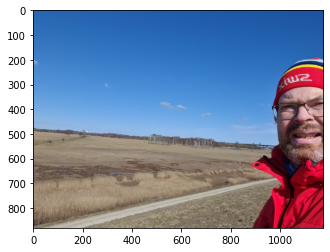

In [49]:
import cv2
with open('Temperature_levels.pickle', 'rb') as f:
    temperature_levels_rfc = pickle.load(f)
with open('Temperature_deltas.pickle', 'rb') as f:
    temperature_deltas_rfc = pickle.load(f)
with open('Warmer_or_colder.pickle', 'rb') as f:
    warcol_rfc = pickle.load(f)

print('Analyzing this image:')
pic_image = mpimg.imread("User Input/" + user_picture)
plt.imshow(pic_image)

In [50]:
pic_image_1 = cv2.imread("User Input/" + user_picture)
pic_image_1 = cv2.resize(pic_image_1, (300, 300))
pic_image_1 = pic_image_1.flatten()
pic_image_1 = asarray(pic_image_1)
print('Predicted temperature when the picture was taken: ')
print(temperature_levels_rfc.predict(np.array(pic_image_1.reshape(1, -1))))
print()
print('Predicted change of temperature to the following day: ')
print(warcol_rfc.predict(np.array(pic_image_1.reshape(1, -1))))
print()
print('Predicted magnitude of temperature change the following day: ')
print(temperature_deltas_rfc.predict(np.array(pic_image_1.reshape(1, -1))))
print()
print('Thank you for using the KAL-VEDDER app - powered by Azure AI')

Predicted temperature when the picture was taken: 
['2.0;3.9']

Predicted change of temperature to the following day: 
['Warmer']

Predicted magnitude of temperature change the following day: 
['0.9;1.7']

Thank you for using the KAL-VEDDER app - powered by Azure AI
